# Import data of london_weather in csv as 'df'
# Remodify data to be monthly

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('./london_weather.csv')
df.drop(columns = ['snow_depth'], inplace = True) # drop the entire column named 'snow_depth'
df.dropna(inplace= True) # drop any NaN 

# if there is NaN data dropped, there will be a gap between index, this code is to reset indexes to be sequent
df.reset_index(drop=True, inplace=True)

# get mean monthly temp
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d') # read 'date' as YearMonthDay, no space or other symbols in the middle
df['month'] = pd.DatetimeIndex(df['date']).month # store the value of Month
df['year'] = pd.DatetimeIndex(df['date']).year # store the value of Year
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M') # combine Year and Month because data will be turned to be monthly
df=df.groupby('month_year').mean() # calculate the average of values in the same month_year in the same column

df=df['mean_temp']# rename the variable 
df=df.to_frame() #transfer 'df' from Series to DataFrame


df




,mean_temp
month_year,
1979-01,0.527586
1979-02,2.028000
1979-03,5.587097
1979-04,8.743333
1979-05,11.490323
...,...
2020-08,20.393333
2020-09,16.616667
2020-10,11.933333


# Split data into train / test sets as the ratio of 8:2

In [2]:
# Split data into train / test sets as the ratio of 8:2
n=int(len(df)*0.2)
train = df.iloc[:len(df)-n]
test = df.iloc[len(df)-n:]

# Find the optimal model by auto_arima

In [4]:
# select p,d,q automatically

# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(df['mean_temp'], # input 'mean_temp' as the dominant variable 
                          m = 12, # set the period to be one month
                          seasonal = True, # turn on the seasonality check
                          trace = True, # report considered ARIMA model
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# Print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3073.607, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2459.229, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3979.973, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2672.683, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1855.231, Time=1.56 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2091.886, Time=0.92 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2337.993, Time=0.91 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2037.249, Time=3.20 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=4.26 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1881.096, Time=1.25 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  504
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -918.876
Date:                              Wed, 05 Apr 2023   AIC                           1851.751
Time:                                      22:35:49   BIC                           1881.309
Sample:                                           0   HQIC                          1863.346
                                              - 504                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0271      0.017      1.607      0.108      -0.006       0.060
ar.L1         -0.9871      0.363     -2.723      0.006      -1.698      -0.277
ma.L1          1.1961      0.364      3.285      0.001       0.483       1.910
ma.L2          0.2069      0.081      2.559      0.011       0.048       0.365
ar.S.L12       0.9988      0.001   1329.517      0.000       0.997       1.000
ma.S.L12      -0.8702      0.031    -28.334      0.000      -0.930      -0.810
sigma2         2.0647      0.124     16.711      0.000       1.823       2.307
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.91   Prob(JB):                         0.09
Heteroskedasticity (H):               0.76   Skew:                            -0.09
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Build up ARIMA with optimal parameters selected by auto_arima

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# build up ARIMA Model
# parameters (p, d, q) are determined manually, considering ACF and PACF plots in the other file 'parameter_selection'
model = ARIMA(train['mean_temp'], 
                # order = (1, 0, 2), 
                seasonal_order =(1, 0, 1, 12))


result = model.fit() # Fit (estimate) the parameters of the model.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                mean_temp   No. Observations:                  404
Model:             ARIMA(1, 0, [1], 12)   Log Likelihood                -752.742
Date:                  Thu, 06 Apr 2023   AIC                           1513.483
Time:                          18:11:45   BIC                           1529.489
Sample:                      01-31-1979   HQIC                          1519.819
                           - 08-31-2012                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1535      1.578      7.069      0.000       8.061      14.246
ar.S.L12       0.9990      0.001   1449.140      0.000       0.998       1.000
ma.S.L12      -0.8500      0.034    -25.293      0.000      -0.916      -0.784
sigma2         2.1782      0.148     14.760      0.000       1.889       2.467
===================================================================================
Ljung-Box (L1) (Q):                  12.51   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               0.73   Skew:                            -0.13
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
result.aic
# the lower the better, a few thousands for the single variable case, this result is acceptable

1513.483149605817

# Predicting from the end of the training set until 60 months after the entire set 'df'

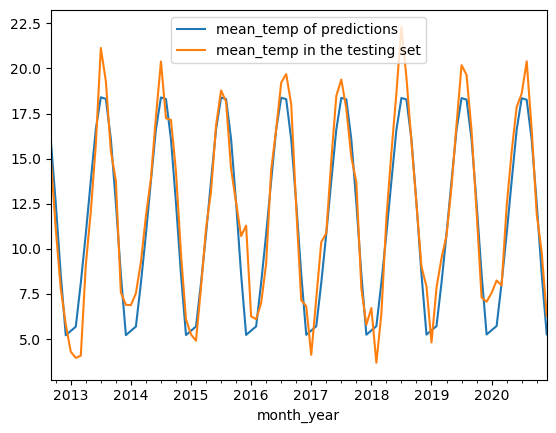

In [7]:
#Predictions of ARIMA Model against the test set
start = len(train)
end = len(df)+60 # next 60 months

# Predictions for one-year against the test set
predictions = result.predict(start, end, dynamic=True)#dynamic = True means new predicted values will be attached to the end of original datasets for further steps

# plot predictions and actual values on the same axis
predictions.iloc[:len(test)].plot(legend = True)
test['mean_temp'].plot(legend = True)

plt.legend(["mean_temp of predictions", "mean_temp in the testing set"]) # label values clearly

plt.show()


# Validation

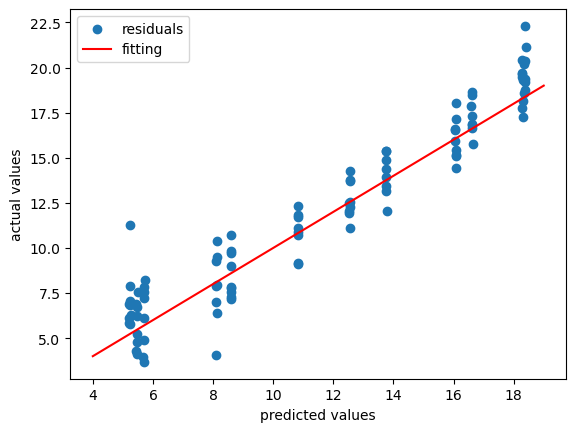

In [9]:
#plot residuals to see errors intuitively
plt.scatter(predictions.iloc[:len(test)], test)
plt.xlabel('predicted values')
plt.ylabel('actual values')

# plot fitting values as reference
x=pd.Series(range(4,20))
y=x
plt.plot(x, y, color='red')

plt.legend(["residuals", "fitting"]) #label values clearly

plt.show()

In [10]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
RMSE=rmse(test["mean_temp"], predictions.iloc[:len(test)])
  
# Calculate mean squared error
ERROR=mean_squared_error(test["mean_temp"], predictions.iloc[:len(test)])

In [11]:
ERROR

2.2824571860685063

In [12]:
RMSE

1.5107803235641197

# Forecasting 5 years

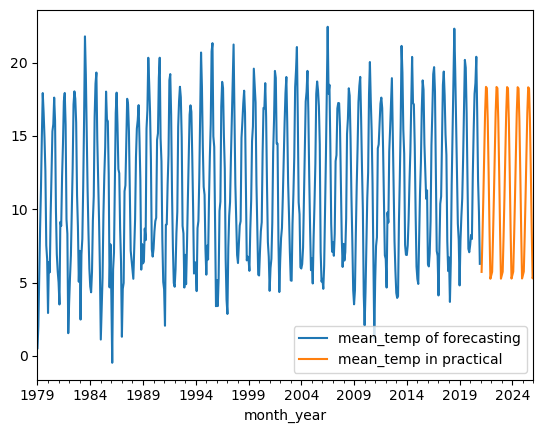

In [13]:
df['mean_temp'].plot(legend = True)
predictions.iloc[-60:].plot(legend = True)

plt.legend(["mean_temp of forecasting", "mean_temp in practical"])
plt.show()

#store predicted values in a csv file
predictions.to_csv('forecast_single_auto.csv', header=True, index=False, encoding='utf-8')


In [14]:
predictions

2012-09    16.092459
2012-10    12.546198
2012-11     8.582815
2012-12     5.207834
2013-01     5.447036
             ...    
2025-09    16.028222
2025-10    12.528085
2025-11     8.616250
2025-12     5.285165
2026-01     5.521256
Freq: M, Name: predicted_mean, Length: 161, dtype: float64

In [15]:
test

,mean_temp
month_year,
2012-09,15.133333
2012-10,11.125806
2012-11,7.803333
2012-12,5.812903
2013-01,4.296774
...,...
2020-08,20.393333
2020-09,16.616667
2020-10,11.933333
